In [30]:
import pandas as pd
import matplotlib.pyplot as plt


#arquivo de dados
df = pd.read_csv("../data/dataset.csv")

casas_sem_preco = df[df['Price'].isnull()].copy()


# Mapeamento dos códigos para nomes completos
mapa_tipo = {
    'h': 'Casa',
    'u': 'Apartamento',
    't': 'Terreno'
}

# Aplicar o mapeamento



# renomear as colunas para português
df.rename(columns={
    'Suburb': 'Subúrbio',
    'Address': 'Endereço',
    'Rooms': 'Salas',
    'Type': 'Tipo',
    'Price': 'Preço',
    'Method': 'Método de Venda',
    'SellerG': 'Vendedor',
    'Date': 'Data',
    'Distance': 'Distância',
    'Postcode': 'Código Postal',
    'Bedroom2': 'Quartos',
    'Bathroom': 'Banheiros',
    'Car': 'Garagem',
    'Landsize': 'Tamanho do Terreno',
    'BuildingArea': 'Área Construída',
    'YearBuilt': 'Ano de Construção',
    'CouncilArea': 'Área Administrativa',
    'Lattitude': 'Latitude',
    'Longtitude': 'Longitude',
    'Regionname': 'Nome da Região',
    'Propertycount': 'Quantidade de Imóveis na Região'
}, inplace=True)

df['Tipo'] = df['Tipo'].map(mapa_tipo)


#display(df.head())


Formato do DataFrame (linhas, colunas): (34857, 21)

Número total de linhas completas: 8887

Colunas com valores ausentes (ordem decrescente):
Área Construída                    21115
Ano de Construção                  19306
Tamanho do Terreno                 11810
Garagem                             8728
Banheiros                           8226
Quartos                             8217
Longitude                           7976
Latitude                            7976
Preço                               7610
Nome da Região                         3
Área Administrativa                    3
Quantidade de Imóveis na Região        3
Código Postal                          1
Distância                              1
Endereço                               0
Data                                   0
Vendedor                               0
Método de Venda                        0
Tipo                                   0
Salas                                  0
Subúrbio                            

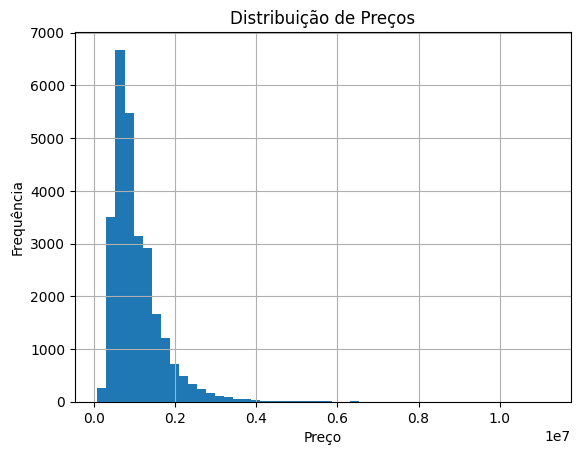


 Total de linhas duplicadas: 1


None

"\n# Contar quantos NaN existem por bairro\ndf_nan_garagem = df[df['Garagem'].isnull()]\nnan_garagem_por_bairro = df_nan_garagem.groupby('Subúrbio').size().sort_values(ascending=False)\nprint(nan_garagem_por_bairro)\n"

In [31]:
def dados_estatisticos(df):
    print("\nFormato do DataFrame (linhas, colunas):", df.shape)
    print("\nNúmero total de linhas completas:", df.dropna().shape[0])
    print("\nColunas com valores ausentes (ordem decrescente):")
    print(df.isnull().sum().sort_values(ascending=False))

    print("\nEstatísticas descritivas para colunas numéricas:")
    print(df.describe())


    print("\nFrequência relativa das colunas categóricas :")
    for col in df.select_dtypes(include='object').columns:
        print(f"\n{col}:")
        print(df[col].value_counts(normalize=True).head(10))
    
    if 'Preço' in df.columns:
        print("\nCorrelação com a coluna 'Preço':")
        print(df.corr(numeric_only=True)['Preço'].sort_values(ascending=False))

        print("\n Histograma da variável 'Preço':")
        df['Preço'].hist(bins=50)
        plt.xlabel("Preço")
        plt.ylabel("Frequência")
        plt.title("Distribuição de Preços")
        plt.grid(True)
        plt.show()
        

    print("\n Total de linhas duplicadas:", df.duplicated().sum())
    

display(dados_estatisticos(df))

'''
# Contar quantos NaN existem por bairro
df_nan_garagem = df[df['Garagem'].isnull()]
nan_garagem_por_bairro = df_nan_garagem.groupby('Subúrbio').size().sort_values(ascending=False)
print(nan_garagem_por_bairro)
'''


In [32]:
# como visto anteriormente, dados ausentes podem afetar a análise, então é importante tratá-los
# Área Construída, Ano de Construção e Área Administrativa são colunas com muitos valores ausentes
df.drop(columns=['Área Construída', 'Ano de Construção', 'Área Administrativa', 'Vendedor'], inplace=True)
#df = df.dropna(subset=['Preço'])


#Colunas como garagem, banheiros e quartos podem ser preenchidos com a mediana, separados por bairro 
def preencher_por_bairro(df, col):
    # mediana da coluna por bairro
    mediana_por_bairro = df.groupby('Subúrbio')[col].median()

    # Função auxiliar que preenche com a mediana do bairro ou com a mediana global
    def preencher(row):
        if pd.isna(row[col]):
            bairro = row['Subúrbio']
            # se o bairro não está no índice ou a mediana é NaN, usa a mediana global PODE ALTERAR RESULTADOS
            if bairro in mediana_por_bairro and not pd.isna(mediana_por_bairro[bairro]):
                return mediana_por_bairro[bairro]
            else:
                return df[col].median()
        else:
            return row[col]

    df[col] = df.apply(preencher, axis=1)
    return df

preencher_por_bairro(df, 'Garagem')
preencher_por_bairro(df, 'Banheiros')
preencher_por_bairro(df, 'Quartos')
df['Subúrbio'].value_counts().head(60)


display(df)

,Subúrbio,Endereço,Salas,Tipo,Preço,Método de Venda,Data,Distância,Código Postal,Quartos,Banheiros,Garagem,Tamanho do Terreno,Latitude,Longitude,Nome da Região,Quantidade de Imóveis na Região
0,Abbotsford,68 Studley St,2,Casa,NaN,SS,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,-37.80140,144.99580,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,Casa,1480000.0,S,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,-37.79960,144.99840,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,Casa,1035000.0,S,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,-37.80790,144.99340,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,Apartamento,NaN,VB,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,-37.81140,145.01160,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,Casa,1465000.0,SP,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,-37.80930,144.99440,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,Yarraville,13 Burns St,4,Casa,1480000.0,PI,24/02/2018,6.3,3013.0,4.0,1.0,3.0,593.0,-37.81053,144.88467,Western Metropolitan,6543.0
34853,Yarraville,29A Murray St,2,Casa,888000.0,SP,24/02/2018,6.3,3013.0,2.0,2.0,1.0,98.0,-37.81551,144.88826,Western Metropolitan,6543.0
34854,Yarraville,147A Severn St,2,Terreno,705000.0,S,24/02/2018,6.3,3013.0,2.0,1.0,2.0,220.0,-37.82286,144.87856,Western Metropolitan,6543.0
34855,Yarraville,12/37 Stephen St,3,Casa,1140000.0,SP,24/02/2018,6.3,3013.0,3.0,1.0,1.0,NaN,NaN,NaN,Western Metropolitan,6543.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Separar dados com preço
df_com_preco = df[df['Preço'].notna()].copy()

# Separar colunas de entrada e alvo
colunas_para_remover = ['Preço', 'Endereço', 'Data']
X = df_com_preco.drop(columns=colunas_para_remover, errors='ignore')
y = df_com_preco['Preço']

# Codificar categorias
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(X.median(numeric_only=True))

# Separar treino e teste (opcional, para avaliação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)


In [39]:
# Selecionar casas sem preço
df_sem_preco = df[df['Preço'].isna()].copy()
#display(df_sem_preco)

# Preparar entradas para previsão
X_novas = df_sem_preco.drop(columns=colunas_para_remover, errors='ignore')
X_novas = pd.get_dummies(X_novas, drop_first=True)

# Garantir que X_novas tenha as mesmas colunas que X_train
X_novas = X_novas.reindex(columns=X.columns, fill_value=0)

# Prever
df_sem_preco['Preço_Previsto'] = modelo.predict(X_novas)
# Exibir as primeiras linhas com os preços previstos
display(df_sem_preco[['Subúrbio', 'Endereço', 'Preço_Previsto']].head(100))


,Subúrbio,Endereço,Preço_Previsto
0,Abbotsford,68 Studley St,1.053435e+06
3,Abbotsford,18/659 Victoria St,1.104690e+06
7,Abbotsford,16 Maugie St,2.048893e+06
8,Abbotsford,53 Turner St,1.184100e+06
9,Abbotsford,99 Turner St,1.296490e+06
...,...,...,...
469,Armadale,4/38 Northcote Rd,6.405800e+05
470,Armadale,4/576 Orrong Rd,5.422783e+05
472,Armadale,896 Malvern Rd,1.553783e+06
475,Armadale,8 Derby St,1.963760e+06
